<a href="https://colab.research.google.com/github/dkanzariya/AI-Notebooks/blob/master/Conv_Architecture_Ruff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#fashion mnist

#LeNet-5 (http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)


In [ ]:
#Book : Dive in to Deep Learning ( d2l.ai )
!pip install d2l==0.16.1

     |████████████████████████████████| 81kB 2.8MB/s 


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
from dataclasses import dataclass
from torch.nn import functional as F

In [ ]:
import torchvision

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
class Reshape(torch.nn.Module):
  def forward(self,x):
    return x.view(-1,1,28,28)

LeNet_5 = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size = 5, padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6, 16, kernel_size = 5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5, 120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10))
  

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
LeNet_5_batchnorm = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 10)) #, nn.BatchNorm1d(120), nn.Sigmoid(),
    # nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    # nn.Linear(84, 10))

net = LeNet_5_batchnorm
# net = LeNet_5

X = torch.rand(size = (1,1,28,28),dtype = torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__,__name__,'output shape: \t\t\t',X.shape)

<class 'torch.nn.modules.conv.Conv2d'> __main__ output shape: 			 torch.Size([1, 6, 24, 24])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> __main__ output shape: 			 torch.Size([1, 6, 24, 24])
<class 'torch.nn.modules.activation.Sigmoid'> __main__ output shape: 			 torch.Size([1, 6, 24, 24])
<class 'torch.nn.modules.pooling.MaxPool2d'> __main__ output shape: 			 torch.Size([1, 6, 12, 12])
<class 'torch.nn.modules.conv.Conv2d'> __main__ output shape: 			 torch.Size([1, 16, 8, 8])
<class 'torch.nn.modules.batchnorm.BatchNorm2d'> __main__ output shape: 			 torch.Size([1, 16, 8, 8])
<class 'torch.nn.modules.activation.Sigmoid'> __main__ output shape: 			 torch.Size([1, 16, 8, 8])
<class 'torch.nn.modules.pooling.MaxPool2d'> __main__ output shape: 			 torch.Size([1, 16, 4, 4])
<class 'torch.nn.modules.flatten.Flatten'> __main__ output shape: 			 torch.Size([1, 256])
<class 'torch.nn.modules.linear.Linear'> __main__ output shape: 			 torch.Size([1, 10])


In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):  #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required for BERT Fine-tuning (to be covered later)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.285, train acc 0.899, test acc 0.828
23993.7 examples/sec on cuda:0


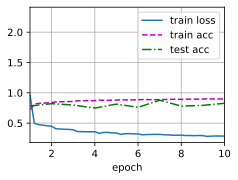

In [ ]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
AlexNet = nn.Sequential(
      nn.Conv2d(1, 96, kernel_size = 11, padding=1, stride=4),nn.ReLU(),
      nn.MaxPool2d(kernel_size=3,stride=2),
      nn.Conv2d(96, 256, kernel_size = 5, padding=2 ),nn.ReLU(),
      nn.MaxPool2d(kernel_size=3,stride=2),
      nn.Conv2d(256, 384, kernel_size = 3, padding=1 ),nn.ReLU(),
      nn.Conv2d(384, 384, kernel_size = 3, padding=1 ),nn.ReLU(),
      nn.Conv2d(384, 256, kernel_size = 3, padding=1 ),nn.ReLU(),    
      nn.MaxPool2d(kernel_size = 3, stride = 2),
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(6400,4096), nn.ReLU(),
      nn.Dropout(p = 0.5),
      nn.Linear(4096,4096), nn.ReLU(),
      nn.Linear(4096,10))

In [ ]:
net = AlexNet

X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([1, 96, 54, 54])
ReLU Output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([1, 96, 26, 26])
Conv2d Output shape:	 torch.Size([1, 256, 26, 26])
ReLU Output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([1, 256, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 384, 12, 12])
ReLU Output shape:	 torch.Size([1, 384, 12, 12])
Conv2d Output shape:	 torch.Size([1, 256, 12, 12])
ReLU Output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([1, 256, 5, 5])
Flatten Output shape:	 torch.Size([1, 6400])
Dropout Output shape:	 torch.Size([1, 6400])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Dropout Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1, 4096])
ReLU Output shape:	 torch.Size([1, 4096])
Linear Output shape:	 torch.Size([1,

In [ ]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

loss 0.512, train acc 0.810, test acc 0.827
1411.0 examples/sec on cuda:0


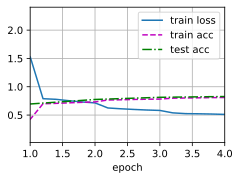

In [ ]:
lr, num_epochs = 0.01, 4
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
def vgg_blocks(num_convs, in_channel, out_channel):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.Conv2d(in_channel, out_channel, kernel_size = 3, padding=1))
    layers.append(nn.ReLU())
    in_channel = out_channel
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

def vgg(conv_arch):
  conv_blks = []
  in_channel = 1
  for (num_convs, out_channel) in conv_arch:
    conv_blks.append(vgg_blocks(num_convs, in_channel, out_channel))
    in_channel = out_channel
  return nn.Sequential(
      *conv_blks, nn.Flatten(), 
      nn.Linear(out_channel*7*7, 4096),nn.ReLU(),nn.Dropout(0.5),
                nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
                nn.Linear(4096,10))
  

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

net = vgg(conv_arch)

X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


loss 0.405, train acc 0.852, test acc 0.870
646.6 examples/sec on cuda:0


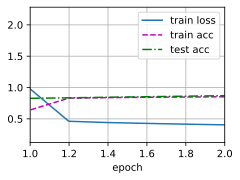

In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 2, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
def nin_block(in_channel,out_channel,kernel_size,padding,stride):
  return nn.Sequential(
      nn.Conv2d(in_channel,out_channel,kernel_size,stride,padding),
      nn.ReLU(),
      nn.Conv2d(out_channel,out_channel,kernel_size=1), nn.ReLU(),
      nn.Conv2d(out_channel, out_channel, kernel_size=1), nn.ReLU())
  
nin = nn.Sequential(
    nin_block(1, 96, kernel_size=11, padding=0, stride=4),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, padding=2, stride=1),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, padding=1, stride=1),
    nn.MaxPool2d(3, stride=2) ,   
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, padding=1, stride=1),
    nn.AdaptiveMaxPool2d((1,1)),
    nn.Flatten()) 

In [ ]:
net = nin

X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveMaxPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.518, train acc 0.796, test acc 0.796
1012.4 examples/sec on cuda:0


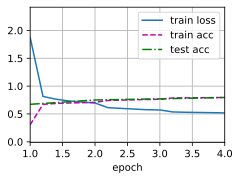

In [ ]:
lr, num_epochs, batch_size = 0.1, 4, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
class inception(nn.Module):
  
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(inception,self).__init__(**kwargs)
    
    self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)

    self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)

    self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
    self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)

    self.p4_1 = nn.MaxPool2d(kernel_size=3, padding=1, stride=1)
    self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

  def forward(self,x):
      p1 = F.relu(self.p1_1(x))
      p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
      p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
      p4 = F.relu(self.p4_2(self.p4_1(x)))
      return torch.cat((p1, p2, p3, p4), dim=1)

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(inception(192, 64, (96, 128),  (16, 32), 32),
                   inception(256, 128, (128, 192), (32,96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(inception(480, 192, (96, 208), (16,48), 64),
                   inception(512, 160, (112, 224), (24, 64), 64),
                   inception(512, 128, (128, 256), (24,64), 64),
                   inception(512, 112, (144, 288), (32, 64), 64),
                   inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(inception(832, 256, (160, 320), (32, 128), 128),
                   inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveMaxPool2d((1,1)),
                   nn.Flatten())


loss 0.231, train acc 0.913, test acc 0.899
1303.6 examples/sec on cuda:0


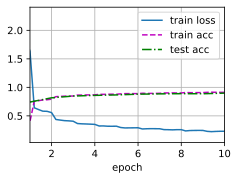

In [ ]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
class Residual(nn.Module):  #@save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

loss 0.255, train acc 0.906, test acc 0.804
1245.0 examples/sec on cuda:0


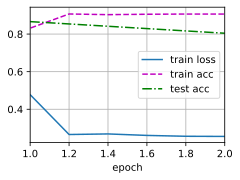

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

lr, num_epochs, batch_size = 0.05, 2, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))
    
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))
    
blk = transition_block(23, 10)
blk(Y).shape

b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# `num_channels`: the current number of channels
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that halves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveMaxPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

In [ ]:
lr, num_epochs, batch_size = 0.1, 4, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

training on cuda:0


In [ ]:
# Batch Norm
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  if not torch.is_grad_enabled():
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2,4)
    if len(X.shape) == 2:
      mean = X.mean(dim = 0)
      var = ((X - mean) ** 2).mean(dim = 0)
    else:
      mean = X.mean(dim = (0,2,3), keepdim = True)
      var = ((X - mean) ** 2).mean(dim = (0, 2,3), keepdim = True)
    X_hat = (X - mean) / torch.sqrt(var + eps)

    moving_mean = momentum * moving_mean + (1 - momentum) * mean
    moving_var = momentum * moving_var + (1 - momentum) * var
  Y = gamma * X_hat + beta
  return Y, moving_mean, moving_var 

class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter involved in gradient
        # finding and iteration are initialized to 0 and 1 respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # All the variables not involved in gradient finding and iteration are
        # initialized to 0 on the CPU
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.zeros(shape)

    def forward(self, X):
        # If X is not on the CPU, copy moving_mean and moving_var to the
        # device where X is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated moving_mean and moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y


In [ ]:
# net = LeNet_5_batchnorm

net = LeNet_5

# net = AlexNet

## vgg
# conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))  
# net = vgg(conv_arch)  

# net = nin

# net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10)) # GoogLeNet 

X = torch.rand(size = (1,1,28,28),dtype = torch.float32)
for layer in net:
  X = layer(X)
  print(layer.__class__,__name__,'output shape: \t\t\t',X.shape)


<class '__main__.Reshape'> __main__ output shape: 			 torch.Size([1, 1, 28, 28])
<class 'torch.nn.modules.conv.Conv2d'> __main__ output shape: 			 torch.Size([1, 6, 28, 28])
<class 'torch.nn.modules.activation.Sigmoid'> __main__ output shape: 			 torch.Size([1, 6, 28, 28])
<class 'torch.nn.modules.pooling.AvgPool2d'> __main__ output shape: 			 torch.Size([1, 6, 14, 14])
<class 'torch.nn.modules.conv.Conv2d'> __main__ output shape: 			 torch.Size([1, 16, 10, 10])
<class 'torch.nn.modules.activation.Sigmoid'> __main__ output shape: 			 torch.Size([1, 16, 10, 10])
<class 'torch.nn.modules.pooling.AvgPool2d'> __main__ output shape: 			 torch.Size([1, 16, 5, 5])
<class 'torch.nn.modules.flatten.Flatten'> __main__ output shape: 			 torch.Size([1, 400])
<class 'torch.nn.modules.linear.Linear'> __main__ output shape: 			 torch.Size([1, 120])
<class 'torch.nn.modules.activation.Sigmoid'> __main__ output shape: 			 torch.Size([1, 120])
<class 'torch.nn.modules.linear.Linear'> __main__ output sha

In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):   
    if not device:
        device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), sum(y.shape))
    return metric[0] / metric[1]

In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr, 
              device=d2l.try_gpu()):
  
    """Train and evaluate a model """
    
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()            
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) 
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (train_loss, train_acc, test_acc))
    print('%.1f examples/sec on %s' % (metric[2]*num_epochs/timer.sum(), device))

loss 0.703, train acc 0.722, test acc 0.671
30522.2 examples/sec on cuda:0


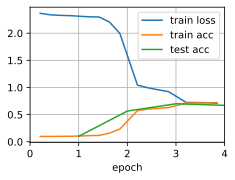

In [ ]:
lr, num_epochs = 1, 4 
train(net, train_iter, test_iter, num_epochs, lr)

In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

lr, num_epochs = 0.05 , 4
train(net, train_iter, test_iter, num_epochs, lr)

NameError: ignored